Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


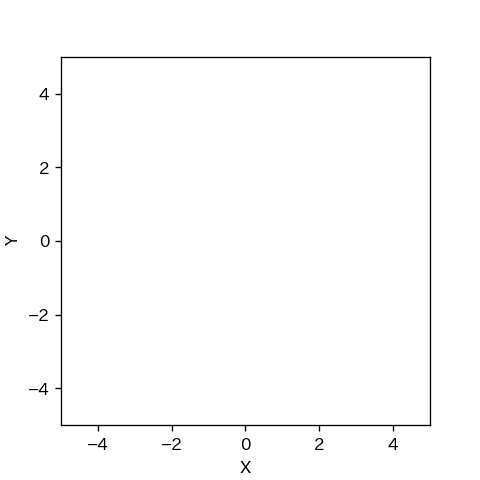

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


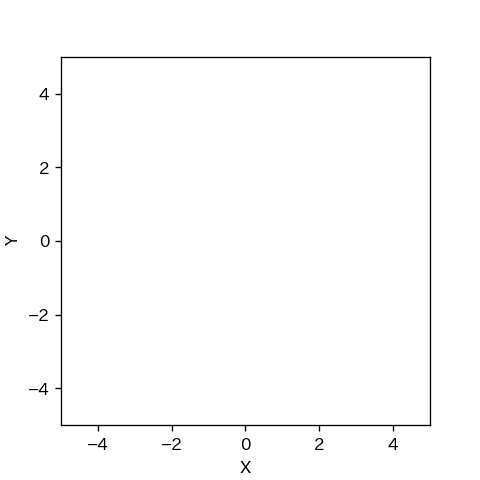

(array([-3.01204888, -1.63061545, -2.00522801]),
 array([ 3.85984823, -3.66560664,  0.1709038 ]))

In [4]:
trial_trap_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[4.152184842443851]
[4.9940035415653545, 5.215210906202268]
0 真値: [2.62376996 2.20712305 1.42430493] 推定値: [2.72939377 2.26531548 1.551974  ] 誤差: 0.12059331568580114
1
[2.171059948684692]
1 真値: [ 3.9160916  -5.03886253  6.3214921 ] 推定値: [ 3.42184217 -2.60955523  2.77699198] 誤差: 2.4790757237773384
2 真値: [-6.80234374  3.58468903  4.64004837] 推定値: [ 3.51007634 -0.67535033  3.31934928] 誤差: 11.1576853860442
[6.227268844084916]
3 真値: [-1.62055143 -4.03279669  2.36887514] 推定値: [ 3.59509679 -8.09438109  5.09539468] 誤差: 6.610556262260903
[3.8745368482949574]
4 真値: [-3.56631955  4.38926297  4.64821072] 推定値: [-4.39834414  0.03433852  1.44688868] 誤差: 4.43369280765456
5 真値: [4.01380174 6.33160666 3.13011923] 推定値: [ 2.29361281 -5.27476306  6.94819523] 誤差: 11.733152523018365
6 真値: [-5.25396751 -4.02992762  5.91214712] 推定値: [ 0.78203064 -0.27586428  4.12752607] 誤差: 7.108182982577019
[6.2681730663873445]
7 真値: [-0.97964388 -3.75476667  5.06498508] 推定値: [-5.24954715  7.72312265  1.69841984] 誤差: 12.246387

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.9527059450164637]
20 真値: [-0.07618247  3.9925673   0.18679199] 推定値: [0.30124152 3.65172334 0.15245711] 誤差: 0.5085503642060789
5
[1.622284317270377]
21 真値: [-4.82885904  2.49267008  2.99215955] 推定値: [-2.11970709  0.8599953   0.60116755] 誤差: 3.163088877991512
[3.5417138410516538]
[2.6771687862214244, 4.515177332299927]
22 真値: [-0.18208934 -0.66476756  6.10757017] 推定値: [-0.13504945 -0.13409237 -0.33986693] 誤差: 0.5327559522073748
6
[5.42152213455033]
[2.322523594763185, 4.6008475972207945]
23 真値: [ 2.98799152 -2.8292963   4.38945417] 推定値: [ 2.85367274 -2.62630358  4.50526197] 誤差: 0.24340825823175966
7
[4.962610242684635]
24 真値: [-2.41318796 -0.98054388  4.35371282] 推定値: [-7.54515618  2.91195119  3.14583967] 誤差: 6.441165707403551
[6.351685774111307, 4.965491682034493]
25 真値: [-3.26466385 -1.93058517  2.95940068] 推定値: [-4.00202611 -1.59436913  2.7316268 ] 誤差: 0.810397637988687
8
[2.574572193701228]
26 真値: [-5.11445104  2.69062034  6.12012755] 推定値: [-3.83129733  3.15057981 -1.34213913] 誤差: